In [1]:
import os
import pickle
import shutil
import glob
import random
from pickle import load
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sn
import datetime

Using TensorFlow backend.


>> Total training images:  25331   at:   /home/vasileiosaidonis/ISIC 2019/Training_Images
>> Total test images:      8238    at:   /home/vasileiosaidonis/ISIC 2019/Test_Images


,image,age_approx,anatom_site_general,lesion_id,sex,dx,label
3663,ISIC_0025066,60.0,upper extremity,HAM_0002749,male,BKL,2
16598,ISIC_0059378,60.0,anterior torso,BCN_0003120,male,BKL,2
20551,ISIC_0065696,85.0,head/neck,BCN_0003500,male,BCC,1
16328,ISIC_0058947,55.0,anterior torso,BCN_0003884,male,MEL,4
11165,ISIC_0032568,40.0,palms/soles,HAM_0007005,female,NV,5
17654,ISIC_0061054,65.0,upper extremity,BCN_0002879,female,BCC,1
22355,ISIC_0068552,30.0,anterior torso,BCN_0005541,male,NV,5
7171,ISIC_0028574,40.0,anterior torso,HAM_0004686,female,NV,5
16858,ISIC_0059771,75.0,anterior torso,BCN_0004130,male,BCC,1
12879,ISIC_0034282,20.0,anterior torso,HAM_0004882,male,NV,5


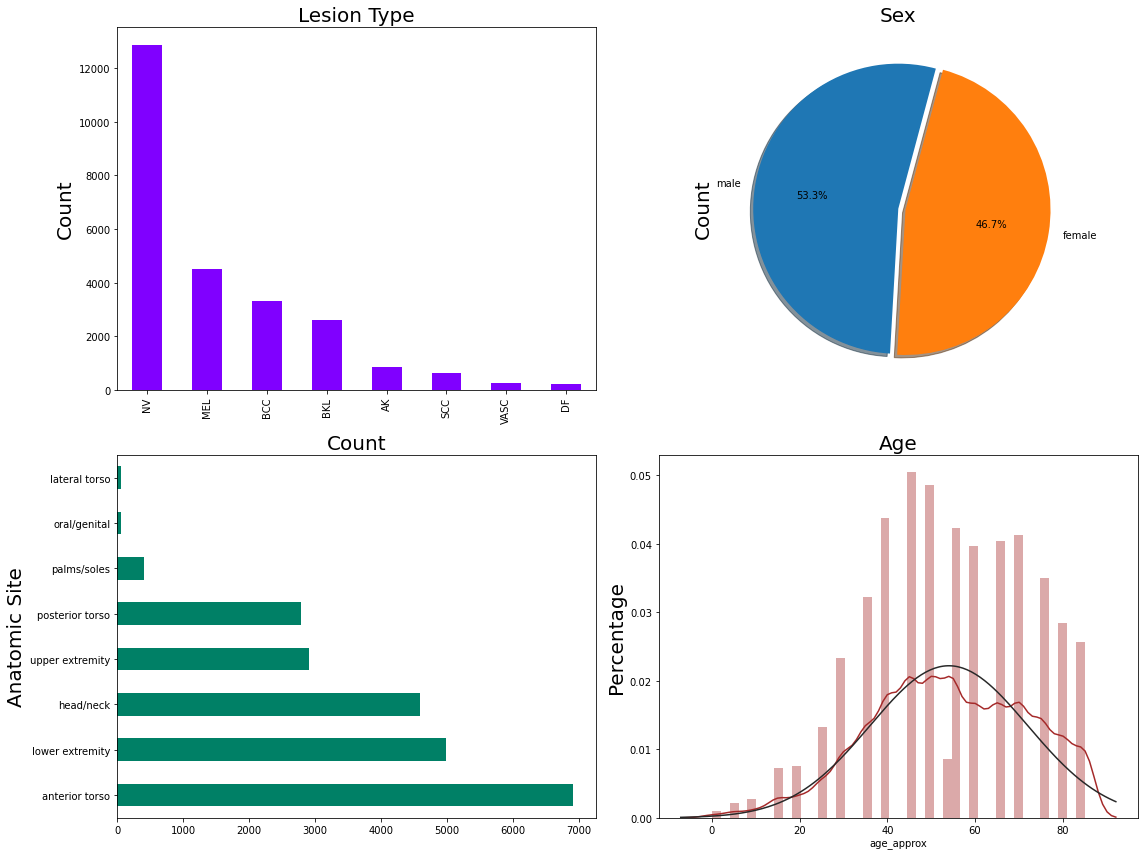

In [2]:
TRAIN_DIR = Path("/home/vasileiosaidonis/ISIC 2019/Training_Images")
TEST_DIR = Path("/home/vasileiosaidonis/ISIC 2019/Test_Images")

num_training_images = len(os.listdir(TRAIN_DIR)) - 1   # Calculates the checkpoint 
num_test_images = len(os.listdir(TEST_DIR)) - 1

print(">> Total training images:  {}   at:   {}".format(num_training_images, TRAIN_DIR))
print(">> Total test images:      {}    at:   {}".format(num_test_images, TEST_DIR))

# Training csv
training_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Training_Metadata.csv")
training_df = pd.DataFrame(training_csv)

# Test csv
test_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Test_Metadata.csv")
test_df = pd.DataFrame(test_csv)

# Add lesion labeling from the GroundTruth csv file to the Training DataFrame 
groundtruth_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth_df = pd.DataFrame(groundtruth_csv)
groundtruth_df["dx"] = groundtruth_df[groundtruth_df.columns[[1,2,3,4,5,6,7,8,9]]].idxmax(axis=1)
df = pd.concat([training_df, groundtruth_df["dx"]], axis=1, join='inner')
df['label'] = pd.Categorical(df['dx']).codes
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)


#display(training_df.head())
#display(test_df)
display(df.sample(12))
#display(df.isnull().sum())

# Plot values of the dataset
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1, colormap='rainbow')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_title('Lesion Type', fontsize=20);

ax2 = fig.add_subplot(222)
df['sex'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                              shadow=True, startangle=75, explode=(0, 0.05))
ax2.set_ylabel('Count', fontsize=20)
ax2.set_title('Sex', fontsize=20);

ax3 = fig.add_subplot(223)
df['anatom_site_general'].value_counts().plot(kind='barh', colormap='summer')
ax3.set_title('Count', fontsize=20)
ax3.set_ylabel('Anatomic Site', fontsize=20)


ax4 = fig.add_subplot(224)
sample_age = df[pd.notnull(df['age_approx'])]
sn.distplot(sample_age['age_approx'], fit=stats.norm, color='brown');
ax4.set_title('Age', fontsize=20)
ax4.set_ylabel('Percentage', fontsize=20)

plt.tight_layout()
plt.show()

In [3]:
# Split to training and validation dataset
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])

train_val_splits = pd.concat([df['dx'].value_counts(), df_train['dx'].value_counts(), df_val['dx'].value_counts()],
                              keys=['ALL_IMAGES','___TRAIN___', 'VALIDATION'], axis=1)

train_val_splits.loc[-1] = [len(df), len(df_train), len(df_val)]
train_val_splits.rename(index={-1:'Total:'},inplace=True)
train_val_splits = train_val_splits.style.set_table_attributes('style="font-size: 15px; \
                                                                border: 1.3px solid #000; \
                                                                background-color: #E9E3D6";')
display(train_val_splits)

,ALL_IMAGES,___TRAIN___,VALIDATION
NV,12875,10300,2575
MEL,4522,3618,904
BCC,3323,2658,665
BKL,2624,2099,525
AK,867,694,173
SCC,628,502,126
VASC,253,202,51
DF,239,191,48
Total:,25331,20264,5067


## Copy images to specified folders

In [4]:
# #Copy images to specific class directories 

# print("All images: ", len(glob.glob("/home/vasileiosaidonis/ISIC 2019/Training_Images/*")))

# train_images = list(df_train['image'] + ".jpg")
# val_images = list(df_val['image'] + ".jpg")

# for image in sorted(glob.glob("/home/vasileiosaidonis/ISIC 2019/Training_Images/*.jpg")):
#     img_name = image[49:]
#     indx = df["image"][df["image"] == img_name[:-4]].index[0]
#     label = df.loc[indx, 'dx']
#     path_from = "/home/vasileiosaidonis/ISIC 2019/Training_Images/" + img_name
#     #print(path_from)    
    
#     if img_name in train_images:
#         path_to = os.path.join("/home/vasileiosaidonis/ISIC 2019/TRAIN", label, img_name)
#         shutil.copyfile(path_from, path_to)

#     if img_name in val_images:
#         path_to = os.path.join("/home/vasileiosaidonis/ISIC 2019/VALIDATION", label, img_name)
#         shutil.copyfile(path_from, path_to)

## Deal with Class Imbalance

In [5]:
# # Deal with class imbalance

# images_per_class = 7000
# deleted_images = len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/NV/")) - images_per_class

# # UNDER-sample the NV dataset
# for image in range(deleted_images):
#     rndm_image = random.choice(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/NV/"))
#     os.remove("/home/vasileiosaidonis/ISIC 2019/TRAIN/NV/" +rndm_image)

    
# # OVER-sample the other datasets using ImageDataGenerator
# for file in os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/"):
    
#     #create a new directory with the specific class and load class images
#     os.mkdir("/home/vasileiosaidonis/ISIC 2019/TESTING")
#     os.mkdir("/home/vasileiosaidonis/ISIC 2019/TESTING/"+file)
    
#     for image in os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/"+file):
#         path_from = os.path.join("/home/vasileiosaidonis/ISIC 2019/TRAIN",file, image)
#         path_to = os.path.join("/home/vasileiosaidonis/ISIC 2019/TESTING", file, image)
#         shutil.copyfile( path_from, path_to)
        
        
#     find_images_needed = images_per_class - len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TESTING/"+file))
#     #print(find_images_needed)
#     classes_to_avoid = ["UNK","NV"]

#     if file not in classes_to_avoid:
#         batch_size = 50
#         TESTING_PATH = "/home/vasileiosaidonis/ISIC 2019/TESTING/"
#         SAVE_PATH = "/home/vasileiosaidonis/ISIC 2019/TRAIN/" + file

#         datagen = ImageDataGenerator(rotation_range=180,
#                                      width_shift_range=0.1,
#                                      height_shift_range=0.1,
#                                      zoom_range=0.1,
#                                      horizontal_flip=True,
#                                      vertical_flip=True,
#                                      fill_mode='nearest')

#         final_datagen = datagen.flow_from_directory(directory=TESTING_PATH,
#                                                     save_to_dir=SAVE_PATH,
#                                                     save_format='jpg',
#                                                     target_size=(224,224),
#                                                     batch_size=batch_size)
    
    
#         num_of_batches = int(np.ceil((find_images_needed)/batch_size))
#         counter = 0
#         for batch in final_datagen:
#             counter +=1
#             if counter > num_of_batches:
#                 break
    
#     # delete directory to re-create for next class
#     shutil.rmtree("/home/vasileiosaidonis/ISIC 2019/TESTING")

In [6]:
print("Size of the classes was:\n")
display(df_train['dx'].value_counts())
print("\nSize of the classes is now:\n")
TOTAL_VAL_IMAGES = len(df_val)
TOTAL_IMAGES = 0
for file in sorted(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/")):
    print(file, len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/"+file)))
    TOTAL_IMAGES =TOTAL_IMAGES + len(os.listdir("/home/vasileiosaidonis/ISIC 2019/TRAIN/"+file))

Size of the classes was:



NV      10300
MEL      3618
BCC      2658
BKL      2099
AK        694
SCC       502
VASC      202
DF        191
Name: dx, dtype: int64


Size of the classes is now:

AK 7040
BCC 7016
BKL 7097
DF 6785
MEL 7068
NV 7000
SCC 6524
UNK 0
VASC 5756


## Preprocess datasets 

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 300 
IMG_WIDTH = 225
EPOCHS = 5

TRAIN_DIR = "/home/vasileiosaidonis/ISIC 2019/TRAIN"
TEST_DIR = "/home/vasileiosaidonis/ISIC 2019/VALIDATION"

train_steps = np.ceil(TOTAL_IMAGES / BATCH_SIZE)
val_steps = np.ceil(TOTAL_VAL_IMAGES/ BATCH_SIZE)


datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1)

datagen_val = ImageDataGenerator(rescale=1./255)

train_data_gen = datagen_train.flow_from_directory(directory=TRAIN_DIR,
                                                   batch_size=BATCH_SIZE,                                           
                                                   shuffle=True,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),  # color_mode='grayscale',
                                                   class_mode='categorical')

val_data_gen = datagen_val.flow_from_directory(directory=TEST_DIR,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='categorical')

test_data_gen = datagen_val.flow_from_directory(directory=TEST_DIR,
                                                batch_size=1,                                              
                                                shuffle=False,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='categorical')

Found 54286 images belonging to 9 classes.
Found 5067 images belonging to 9 classes.
Found 5067 images belonging to 9 classes.


## Specify model

In [8]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                                          include_top=False,
                                          weights='imagenet') 

model_input = MODEL.input
# Training is set to True so Dropout is used during prediction time.
add_gap = tf.keras.layers.GlobalAveragePooling2D()(MODEL.output)
add_pred = tf.keras.layers.Dense(9, activation='softmax')(add_gap)

model = tf.keras.Model(model_input, add_pred)

#model.summary()

In [9]:
%%time

adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#%% metrics
metrics = [tf.keras.metrics.CategoricalAccuracy()]

#%% compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

# model.compile(optimizer="adam",             #tf.keras.optimizers.Adam(), #"adam"
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])



checkpoint_path = "/home/vasileiosaidonis/lesion_classification/checkpoints/cp-{epoch}.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=1) # save every 1 epoch

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=20, # stop if metric wont improve after * epochs  
                                                  restore_best_weights=False)

# Custom learning rate decay callback, CHANGE optimizer
def lr_decay(epoch):
    lr = 1e-4
    if epoch > 10:
        lr = 1e-5
    elif epoch > 30:
        lr = 1e-6
        
    tf.summary.scalar('learning rate', data=lr, step=epoch)    
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_decay)

history = model.fit_generator(train_data_gen,                                               
                              steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
                              callbacks=[cp_callback, early_stopping]
                              )


# Save model & history
model.save("/home/vasileiosaidonis/lesion_classification/Lesion_B0.h5")
with open('/home/vasileiosaidonis/lesion_classification/ModelHistory', 'wb') as h1_file:
    pickle.dump(history.history, h1_file)
    
print("\n--------------------")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
1696/1696 [==============================] - ETA: 0s - loss: 1.4999 - categorical_accuracy: 0.4658
Epoch 00001: saving model to /home/vasileiosaidonis/lesion_classification/checkpoints/cp-1.ckpt
1696/1696 [==============================] - 1344s 792ms/step - loss: 1.4999 - categorical_accuracy: 0.4658 - val_loss: 0.9354 - val_categorical_accuracy: 0.6648
Epoch 2/5
1696/1696 [==============================] - ETA: 0s - loss: 1.0122 - categorical_accuracy: 0.6294
Epoch 00002: saving model to /home/vasileiosaidonis/lesion_classification/checkpoints/cp-2.ckpt
1696/1696 [==============================] - 1321s 779ms/step - loss: 1.0122 - categorical_accuracy: 0.6294 - val_loss: 0.8323 - val_categorical_accuracy: 0.6976
Epoch 3/5
1696/1696 [==============================] - ETA: 0s - loss: 0.8769 - categorical_accuracy: 0.6774
Epoch 00003: saving model to /home/vasileiosaidonis/lesion_classification/checkpo

Using data from the trained model

       loss  categorical_accuracy  val_loss  val_categorical_accuracy
0  1.499882              0.465783  0.935393                  0.664755
1  1.012194              0.629428  0.832334                  0.697587
2  0.876857              0.677406  0.777143                  0.714992
3  0.786292              0.710878  0.747969                  0.722112
4  0.726687              0.732868  0.711993                  0.740111


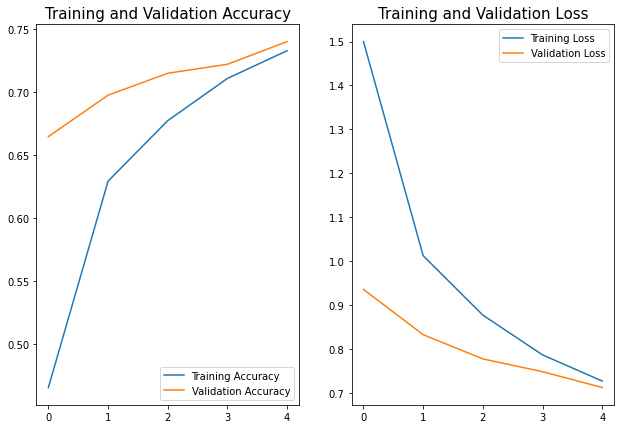

5067/5067 [==============================] - 85s 17ms/step


Text(141.0, 0.5, 'True label')

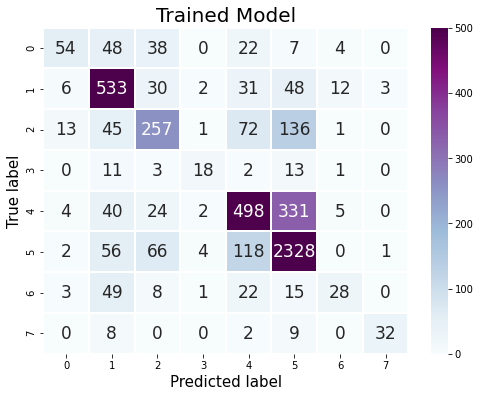

In [45]:
##### Use current history or load from earlier training 
try:
    history
except NameError:
    print(">> Loading model")
    model = tf.keras.models.load_model('./lesion_classification/Lesion_B0.h5')
    print(">> Loading latest model's History from the file\n")
    with open('lesion_classification/ModelHistory', 'rb') as h1_file: 
        old_history = load(h1_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc = old_history['accuracy']
        val_acc = old_history['val_accuracy']
        loss = old_history['loss']
        val_loss = old_history['val_loss']
else:
    print("Using data from the trained model\n")
    history_stats = pd.DataFrame(history.history) 
    print(history_stats.tail())
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

# Find the weights with the best validation accuracy
# In case of early stopping ignore the latest x epochs, where x=9 
# best_weight_simple_model = base_model()
# if (history_stats.index.stop == epochs):
#     best_checkpoint = "./lesion_classification/checkpoints/cp-" + str(val_acc.index(max(val_acc))) +".ckpt"
# else:
#     best_checkpoint = "./lesion_classification/checkpoints/cp-" + str(val_acc.index(max(val_acc[:-9]))) +".ckpt"
# print("\nBest checkpoint at: {}\n".format(best_checkpoint))
# best_weight_simple_model.load_weights(best_checkpoint)


plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()

#val_data_gen.reset()
Y_pred = model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)
y_pred = predictions.argmax(axis=1)


# Append 0 or 1 based on the predictions above.   { 0 CATS, 1 DOGS }
# Easy to specify how strong the correlation is by the number generated.
# Works as it is supposed to do when changing 0 to larger or smaller number
# by increasing the TPs for one class and increasing the FN for the other one.
# y_pred, y2_pred = [], []
# belief = 1.1
# for i in range(total_val):     # Values without changing the threshold
#     if Y_pred[i] > 0:          
#         y_pred.append(1)
#     else:
#         y_pred.append(0)
        
# for i in range(total_val):     # Numbers close to 1+ higher chance of representing a dog
#     if Y_pred[i] > -belief:          # Numbers close to -1 higher chance of representing a cat
#         y2_pred.append(1)
#     else:
#         y2_pred.append(0)
# #print(np.array(y_pred))

labels =['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC'] # 
CM = confusion_matrix(test_data_gen.classes, y_pred)  #, labels
# CM2 = tf.math.confusion_matrix(val_data_gen.classes, y2_pred)

# FP = CM.sum(axis=0) - np.diag(CM) 
# FN = CM.sum(axis=1) - np.diag(CM)
# TP = np.diag(CM)
# TN = CM.sum() - (FP + FN + TP)
# print("FP", FP)
# print("FN", FN)
# print("TP", TP)
# print("TN", TN)

plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.title('Trained Model', fontsize=20, ha='center')
sn.heatmap(CM, annot=True, fmt = "d", cmap="BuPu", vmin=0, vmax=500, linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

# plt.subplot(1,2,2)
# plt.title('Model after changing the threshold', fontsize=20, ha='center')
# sn.heatmap(CM2, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
# plt.xlabel('Predicted label', fontsize=15)
# plt.ylabel('True label', fontsize=15)


# tn, fp, fn, tp = confusion_matrix(val_data_gen.classes, y_pred).ravel()
# tn2, fp2, fn2, tp2 = confusion_matrix(val_data_gen.classes, y2_pred).ravel()


# print("\n\n      The accuracy of classified dogs is: {:.2f}%  and of classified cats {:.2f}%".format(
#      (tp/num_dogs_val)*100, (tn/num_cats_val)*100))
# print("-------------------------------------------------------------------------------------")
# print(" The FALSE NEGATIVES are: {} and they represent {:.2f}% of the wrong classified dogs".format(
#      fn, (fn/num_dogs_val)*100))
# print(" If we want to be --% more precise of the correctly classified dogs".format(belief*100))
# print(" FALSE NEGATIVES are now {:.2f}% which is {:.1f} times more accurate than before".format(
#      (fn2/num_dogs_val)*100, (fn/num_dogs_val)/(fn2/num_dogs_val)))
# print(" This creates a {:.2f}% LOSS of the correctly classified cats(TNs)".format(((tn/tn2)*100)))
# print(" The original accuracy of the cats was {:.2f}% and it became {:.2f}%".format(
#      (tn/num_cats_val)*100, (tn2/num_cats_val)*100))
# print("-------------------------------------------------------------------------------------\n")